### Import necessary packages

In [5]:
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from patsy import dmatrices
from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import naive_bayes
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Read in the dataset

In [2]:
# Kaggle dataset source: https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset?resource=download

df = pd.read_csv('heart.csv')
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


### Explanation for variables

age - Age of the patient

sex - Sex of the patient

cp - Chest pain type: 0 = Typical Angina, 1 = Atypical Angina, 2 = Non-anginal Pain, 3 = Asymptomatic

trtbps - Resting blood pressure (in mm Hg)

chol - Cholestoral in mg/dl fetched via BMI sensor

fbs - (fasting blood sugar > 120 mg/dl): 1 = True, 0 = False

restecg - Resting electrocardiographic results: 0 = Normal, 1 = ST-T wave normality, 2 = Left ventricular hypertrophy

thalachh - Maximum heart rate achieved

oldpeak - Previous peak

slp - Slope

caa - Number of major vessels

thall - Thalium Stress Test result: (0 ~ 3)

exng - Exercise induced angina: 1 = Yes, 0 = No

output - Target variable

### Data processing

In [3]:
print(f'The dataset has {df.shape[0]} entries and {df.shape[1]} columns(variables)\n')
print(df.info())

The dataset has 303 entries and 14 columns(variables)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None


In [64]:
print(df.isnull().sum())
# Luckily there are no missing values in this dataset

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64


### Data cleaning

The variables 'cp' and 'restecg' are currently categorical variables represented by numbers. In order to run a regression model, they have to be in the form of numerical values. I will transform them to numerical variables -- dummy variables by using pd.get_dummies()

In [65]:
cpTransform = []
for value in df['cp']:
	if value == 0:
		cpTransform.append('Typical Angina')
	elif value == 1:
		cpTransform.append('Atypical Angina')
	elif value == 2:
		cpTransform.append('Non-anginal Pain')
	else:
		cpTransform.append('Asymptomatic')
df['cp'] = cpTransform

restecgTransform = []
for value in df['restecg']:
	if value == 0:
		restecgTransform.append('Normal')
	elif value == 1:
		restecgTransform.append('ST-T wave normality')
	else:
		restecgTransform.append('Left ventricular hypertrophy')
df['restecg'] = restecgTransform

onehot1 = pd.get_dummies(df['cp'])
onehot2 = pd.get_dummies(df['restecg'])
df = df.drop(columns=['cp', 'restecg'])
df = df.join(onehot1)
df = df.join(onehot2)
df

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,thall,output,Asymptomatic,Atypical Angina,Non-anginal Pain,Typical Angina,Left ventricular hypertrophy,Normal,ST-T wave normality
0,63,1,145,233,1,150,0,2.3,0,0,1,1,1,0,0,0,0,1,0
1,37,1,130,250,0,187,0,3.5,0,0,2,1,0,0,1,0,0,0,1
2,41,0,130,204,0,172,0,1.4,2,0,2,1,0,1,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,2,0,2,1,0,1,0,0,0,0,1
4,57,0,120,354,0,163,1,0.6,2,0,2,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,123,1,0.2,1,0,3,0,0,0,0,1,0,0,1
299,45,1,110,264,0,132,0,1.2,1,0,3,0,1,0,0,0,0,0,1
300,68,1,144,193,1,141,0,3.4,1,2,3,0,0,0,0,1,0,0,1
301,57,1,130,131,0,115,1,1.2,1,1,3,0,0,0,0,1,0,0,1


### Correlations between variables and the target variable

output      1.000000
cp          0.433798
thalachh    0.421741
slp         0.345877
restecg     0.137230
fbs        -0.028046
chol       -0.085239
trtbps     -0.144931
age        -0.225439
sex        -0.280937
thall      -0.344029
caa        -0.391724
oldpeak    -0.430696
exng       -0.436757
Name: output, dtype: float64


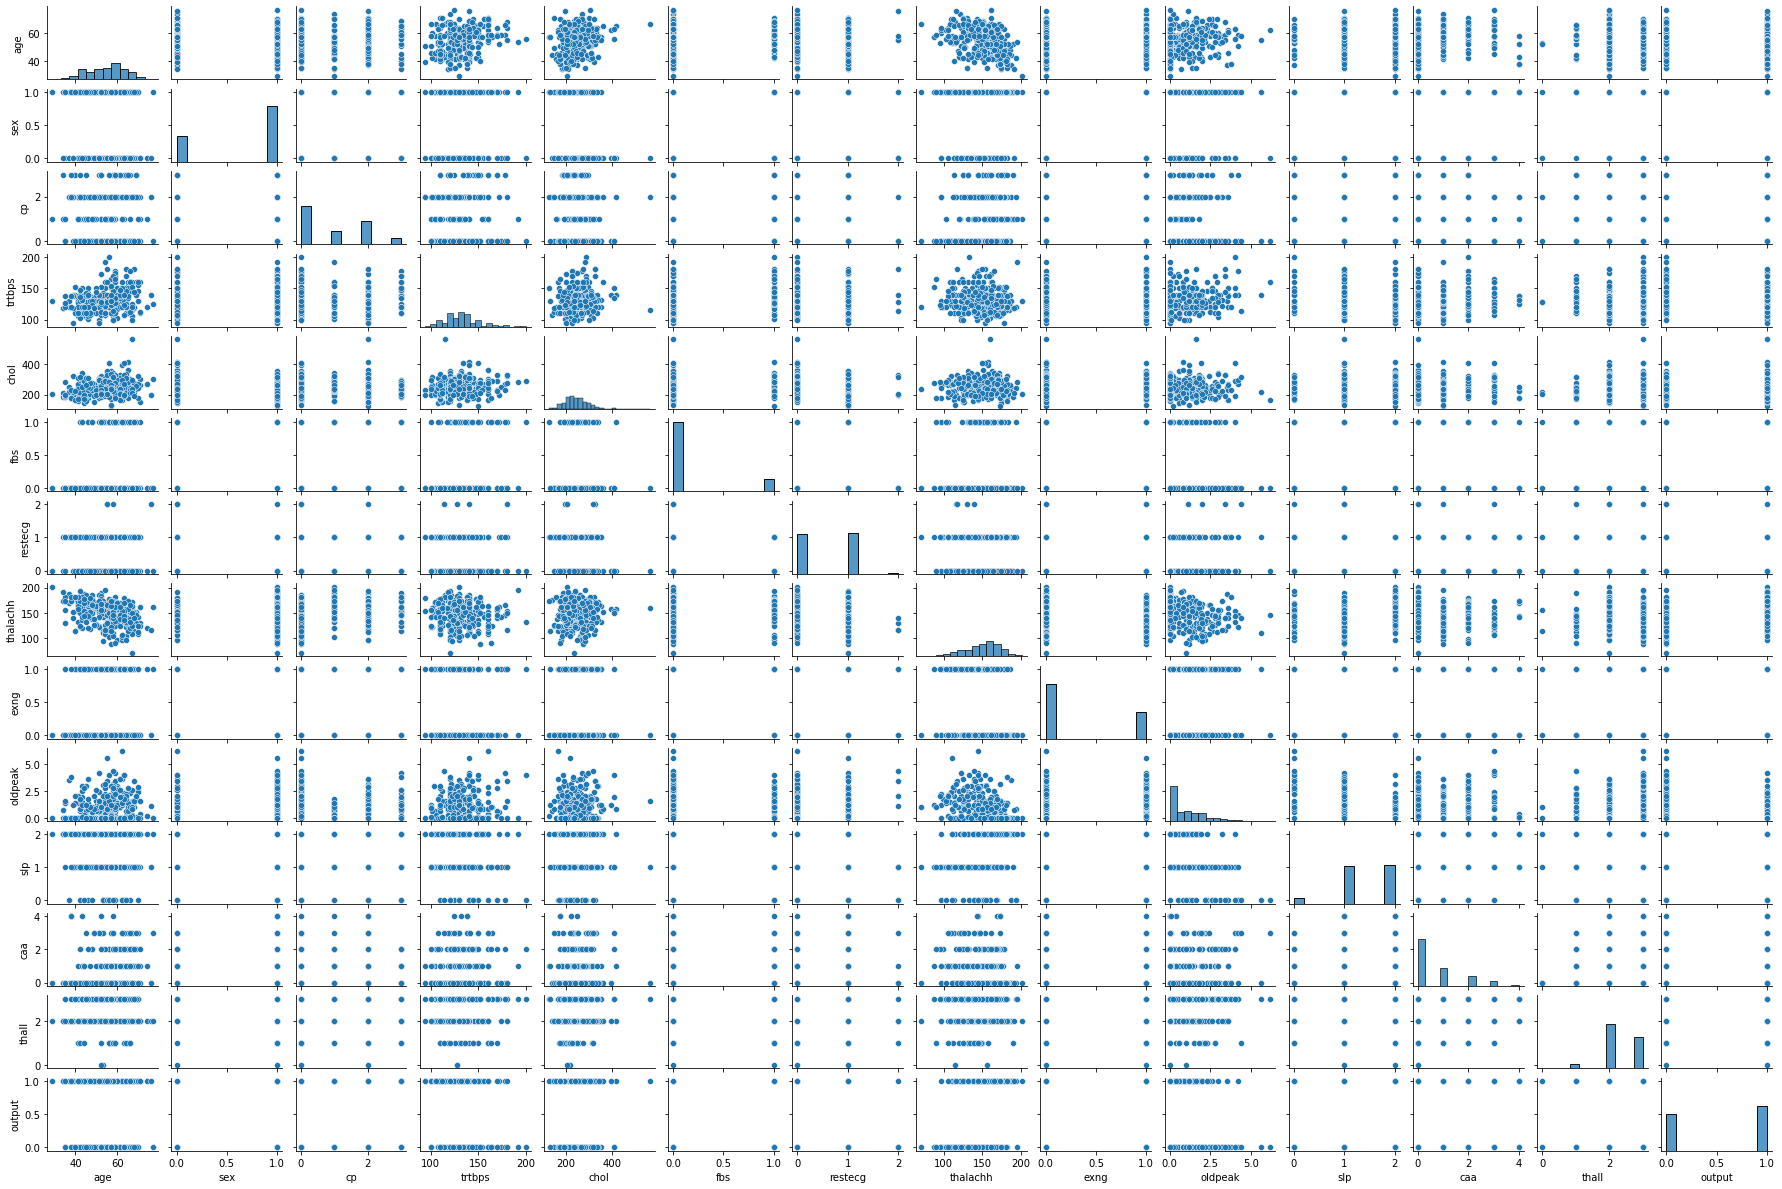

In [6]:
print(df.corr()['output'].sort_values(ascending=False))
sns.pairplot(df, height = 1.2, aspect=1.5)

According to the results above, there are some variables with high correlations such as 'thalachh', 'slp', 'Typical Angina' ...

For the accuracy and simplicity of the model, I will only keep the variables with an absolute value of correlation value greater than 0.2

In [17]:
corr = df.corr()
targetcorr = abs(corr['output'])
relevant_features = targetcorr[targetcorr>0.2]
relevant_features

age         0.225439
sex         0.280937
cp          0.433798
thalachh    0.421741
exng        0.436757
oldpeak     0.430696
slp         0.345877
caa         0.391724
thall       0.344029
output      1.000000
Name: output, dtype: float64

### Logistic regression model

In [20]:
X = df[relevant_features.index]
X = X.drop(columns='output')
y = df['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)
model = LogisticRegression()
model.fit(X_train,y_train)
print('R squared:',model.score(X_test,y_test))

R squared: 0.8552631578947368


In [21]:
print(model.intercept_)
print(model.coef_)

[0.01946483]
[[-0.00160395 -1.05981987  0.77936577  0.01935801 -0.84832235 -0.48835567
   0.34691061 -0.79207004 -0.82939904]]


### Logistic regression model formula:
$$
Output={e^{(0.0195-0.0016X_1-1.0598X_2+0.7794X_3+...-0.8294X_9)}\over{1+e^{(0.0195-0.0016X_1-1.0598X_2+0.7794X_3+...-0.8294X_9)}}}
$$

In [22]:
test_predictions = model.predict(X_test)
print('Model performance on the test set:')
print(classification_report(y_test, test_predictions))
print("Test accuracy:", accuracy_score(y_test, test_predictions))

Model performance on the test set:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85        36
           1       0.85      0.88      0.86        40

    accuracy                           0.86        76
   macro avg       0.86      0.85      0.85        76
weighted avg       0.86      0.86      0.86        76

Test accuracy: 0.8552631578947368


### Model classification interpretations

In [23]:
print(model.classes_)
print(confusion_matrix(y_test, test_predictions))
print('There are', confusion_matrix(y_test, test_predictions)[0][1], 'people who had heart attack but incorrectly predicted to be healthy')
print('There are', confusion_matrix(y_test, test_predictions)[1][0], 'people who were healthy but incorrectly predicted to have heart attack')

[0 1]
[[30  6]
 [ 5 35]]
There are 6 people who had heart attack but incorrectly predicted to be healthy
There are 5 people who were healthy but incorrectly predicted to have heart attack


### Trying different classification models such as Naive Bayes, KNN, Gradient Boosting

In [24]:
model0 = naive_bayes.GaussianNB()
model0 = model0.fit(X_train,y_train)
y_proba_NB = model0.predict_proba(X_test)[:, 1]
print('Naive Bayes train accuracy', model0.score(X_train, y_train))
print('Naive Bayes test accuracy', model0.score(X_test, y_test))
print('Naive Bayes ROC-AUC:', roc_auc_score(y_test, y_proba_NB))
print()


model1 = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000)
model1 = model1.fit(X_train, y_train)
y_proba_LR = model1.predict_proba(X_test)[:, 1]
print('Logistic Reg train accuracy:', model1.score(X_train,y_train))
print('Logistic Reg test accuracy:', model1.score(X_test, y_test))
print('Logistic Reg ROC-AUC:', roc_auc_score(y_test, y_proba_LR))
print()


param_grid = {'n_neighbors': range(1, 20)}
model2 = GridSearchCV(KNeighborsClassifier(),
                    param_grid,
                    cv=3,
                    scoring='accuracy')
model2 = model2.fit(X_train, y_train)
model2 = model2.best_estimator_
y_proba_KNN = model2.predict_proba(X_test)[:, 1]
print('KNN train accuracy:', model2.score(X_train, y_train))
print('KNN test accuracy:', model2.score(X_test, y_test))
print('KNN ROC-AUC:', roc_auc_score(y_test, y_proba_KNN))
print()


model3 = GradientBoostingClassifier()
model3 = model3.fit(X_train, y_train)
y_proba_GB = model3.predict_proba(X_test)[:, 1]
print('Gradient Boosting train accuracy:', model3.score(X_train, y_train))
print('Gradient Boosting test accuracy:', model3.score(X_test, y_test))
print('Gradient Boosting ROC-AUC:', roc_auc_score(y_test, y_proba_GB))

Naive Bayes train accuracy 0.8237885462555066
Naive Bayes test accuracy 0.881578947368421
Naive Bayes ROC-AUC: 0.9416666666666667

Logistic Reg train accuracy: 0.8458149779735683
Logistic Reg test accuracy: 0.8421052631578947
Logistic Reg ROC-AUC: 0.9513888888888888

KNN train accuracy: 0.7224669603524229
KNN test accuracy: 0.7236842105263158
KNN ROC-AUC: 0.8128472222222223

Gradient Boosting train accuracy: 0.9955947136563876
Gradient Boosting test accuracy: 0.8157894736842105
Gradient Boosting ROC-AUC: 0.9229166666666667


### ROC curves for each of the classification models

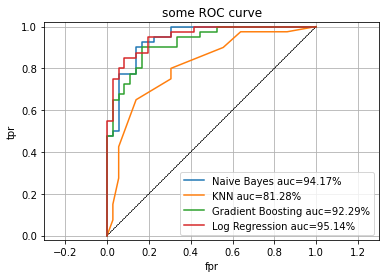

In [25]:
def plot_roc(ytrue, yproba, model, title='some ROC curve'):
    auc = roc_auc_score(ytrue, yproba)
    fpr, tpr, thr = roc_curve(ytrue, yproba)
    plt.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=.4)
    plt.plot(fpr, tpr, label='{} auc={:.2f}%'.format(model, auc*100))
    plt.axis('equal')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)

plot_roc(y_test, y_proba_NB, "Naive Bayes")
plot_roc(y_test, y_proba_KNN, 'KNN')
plot_roc(y_test, y_proba_GB, "Gradient Boosting")
plot_roc(y_test, y_proba_LR, "Log Regression")